In [29]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time
from urllib.parse import urlparse

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


In [31]:
df = pd.read_csv("cleaned_combined_emails.csv", na_values=["", "NA"])

print(f"\nDataset Information:")
print(f"{'='*60}")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"  - Label 0 (Safe emails): {(df['label']==0).sum()}")
print(f"  - Label 1 (Phishing emails): {(df['label']==1).sum()}")
print(f"\nMissing values:")
print(df.isnull().sum())


Dataset Information:
Shape: (76677, 12)
Columns: ['subject', 'body', 'label', 'sender', 'receiver', 'date', 'urls', 'source', 'subject_clean', 'body_clean', 'subject_length', 'body_length']

First few rows:
                                             subject  \
0                          Never agree to be a loser   
1                             Befriend Jenna Jameson   
2                               CNN.com Daily Top 10   
3  Re: svn commit: r619753 - in /spamassassin/tru...   
4                         SpecialPricesPharmMoreinfo   

                                                body  label  \
0  Buck up, your troubles caused by small dimensi...      1   
1  \nUpgrade your sex and pleasures with these te...      1   
2  >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...      1   
3  Would anyone object to removing .so from this ...      0   
4  \nWelcomeFastShippingCustomerSupport\nhttp://7...      1   

                                              sender  \
0                   

In [32]:
df = pd.read_csv("cleaned_combined_emails.csv")


# Helper function to extract domains from a string of space-separated URLs
def extract_domains(url_string):
    if not url_string:
        return ""

    urls = str(url_string).split()
    domains = []
    for url in urls:
        # Prepend scheme if missing for urlparse to work correctly
        if '://' not in url:
             url = 'http://' + url

        try:
            # Use urlparse for robust extraction
            netloc = urlparse(url).netloc
            if netloc:
                # Remove port numbers and www. prefix
                domain = netloc.split(':')[0].replace('www.', '')
                domains.append(domain)
        except:
            continue

    return " ".join(domains)

print(f"Initial shape: {df.shape}")

# -------------------------
# 2. Handle missing values & ensure text
# -------------------------
text_cols_original = ['subject', 'body', 'subject_clean', 'body_clean', 'urls']
categorical_cols = ['sender', 'receiver', 'source']

for col in text_cols_original:
    df[col] = df[col].fillna('').astype(str)

for col in categorical_cols:
    df[col] = df[col].fillna('unknown')

df['date'] = df['date'].fillna('')

# -------------------------
# 3. Derived features (INCLUDING DOMAIN EXTRACTION)
# -------------------------
# Numerical features derived from 'urls'
df['num_urls'] = df['urls'].apply(lambda x: len(str(x).split()) if x else 0)
df['has_url'] = (df['num_urls'] > 0).astype(int)

# NEW TEXT FEATURE: Extracted Domains from URLs (replaces raw 'urls' for TF-IDF)
df['url_domains'] = df['urls'].apply(extract_domains)

# Length features
df['subject_length'] = df['subject'].apply(len)
df['body_length'] = df['body'].apply(len)

# Date features
df['date_parsed'] = pd.to_datetime(df['date'], errors='coerce', utc=True)
df['has_date'] = df['date_parsed'].notna().astype(int)
df['hour'] = df['date_parsed'].dt.hour.fillna(-1).astype(int)
df['weekday'] = df['date_parsed'].dt.weekday.fillna(-1).astype(int)

# Sender domain feature
df['sender_domain'] = df['sender'].apply(lambda x: x.split('@')[-1] if '@' in str(x) else 'unknown')

# -------------------------
# 4. Encode categorical features
# -------------------------
for col in categorical_cols + ['sender_domain']:
    try:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    except ValueError:
        df[col] = 0

# -------------------------
# 5. Safe TF-IDF vectorization (Using new 'url_domains' column)
# -------------------------
text_cols_to_vectorize = ['subject', 'body', 'subject_clean', 'body_clean', 'url_domains']
tfidf_matrices = []
tfidf_cols_used = []
vectorizers = []

print("\n--- Starting Safe TF-IDF Vectorization ---")

for col in text_cols_to_vectorize:
    # Check if the column is entirely empty or only contains whitespace
    if df[col].str.strip().eq('').all():
        print(f"⚠️ Skipping entirely empty column: {col}")
        continue

    # --- MIN_DF and TOKEN_PATTERN ADJUSTMENT ---
    min_df_setting = 5 # Default min_df for regular text columns
    ngram_setting = (1, 2)
    token_pattern_setting = r'(?u)\b\w\w+\b' # Default for natural language

    if col == 'url_domains':
        # Force min_df=1 to include every domain, no matter how rare (Previous fix)
        min_df_setting = 1
        # Domains are single tokens, so only use unigrams
        ngram_setting = (1, 1)
        # FIX: Use a token pattern that captures entire non-whitespace strings (like domains)
        token_pattern_setting = r'(?u)\b\S+\b'

        # Diagnostic check
        all_tokens = df[col].str.split(expand=True).stack()
        unique_domains = all_tokens.nunique() if not all_tokens.empty else 0
        print(f"🔬 Diagnosis for '{col}': Total Unique Domains/Tokens: {unique_domains}")

    # Initialize vectorizer with adjusted settings
    vec = TfidfVectorizer(max_features=5000,
                          ngram_range=ngram_setting,
                          stop_words=None,
                          min_df=min_df_setting,
                          token_pattern=token_pattern_setting) # <--- NEW FIX APPLIED

    try:
        tfidf = vec.fit_transform(df[col])

        # Check after fit: if vocabulary is empty, skip
        if not vec.vocabulary_:
            print(f"❌ Skipping column '{col}' because it resulted in an empty vocabulary after tokenization.")
            continue

        tfidf_matrices.append(tfidf)
        tfidf_cols_used.append(col)
        vectorizers.append((col, vec))
        print(f"✅ Successfully vectorized column: {col} ({tfidf.shape[1]} features)")

    except ValueError as e:
        if "empty vocabulary" in str(e):
            print(f"❌ Skipping column '{col}' due to ValueError: {e}. Data might be too sparse/uniform.")
        else:
            raise

if not tfidf_matrices:
    print("\nERROR: No text columns were successfully vectorized. Cannot proceed with feature combination.")
    exit()

# -------------------------
# 6. Combine numeric/categorical features with TF-IDF
# -------------------------
numeric_features = ['subject_length', 'body_length', 'num_urls', 'has_url', 'has_date', 'hour', 'weekday',
                    'sender', 'receiver', 'source', 'sender_domain']

X_numeric = csr_matrix(df[numeric_features].values)

X_all = hstack([X_numeric] + tfidf_matrices)
y = df['label']

print(f"\nFinal Feature Matrix Shape: {X_all.shape}")

# -------------------------
# 7. Train-test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.2, random_state=42)

# -------------------------
# 8. Train Random Forest
# -------------------------
print("Training Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# -------------------------
# 9. Evaluate
# -------------------------
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"\nRandom Forest Accuracy: {acc:.4f}")

# -------------------------
# 10. Feature importance per column
# -------------------------
importances = model.feature_importances_

# Numeric/categorical features
numeric_importances = importances[:len(numeric_features)]
numeric_importance_df = pd.Series(numeric_importances, index=numeric_features).sort_values(ascending=False)

# Text features: sum TF-IDF importances
text_importance_dict = {}
start_idx = len(numeric_features)
for col in tfidf_cols_used:
    # Find the corresponding TFIDF matrix to get its feature count
    tfidf_matrix = next(tfidf for feature, tfidf in zip(tfidf_cols_used, tfidf_matrices) if feature == col)

    end_idx = start_idx + tfidf_matrix.shape[1]

    # Check if the importance slice is valid
    if end_idx > len(importances):
        print(f"Warning: Importance slicing error for {col}. Skipping importance calculation.")
        text_importance_dict[col] = np.nan
        break

    text_importance_dict[col] = importances[start_idx:end_idx].sum()
    start_idx = end_idx

text_importance_df = pd.Series(text_importance_dict).sort_values(ascending=False).dropna()

# -------------------------
# 11. Show results
# -------------------------
print("\n🎯 Numeric/Categorical Feature Importances:")
print(numeric_importance_df)

print("\n🎯 Raw Text Column Importances:")
print(text_importance_df)

# -------------------------
# 12. Columns to keep (importance >= 0.01)
# -------------------------
all_feature_importance = pd.concat([numeric_importance_df, text_importance_df])
print(all_feature_importance)

Initial shape: (76677, 12)

--- Starting Safe TF-IDF Vectorization ---
✅ Successfully vectorized column: subject (5000 features)
✅ Successfully vectorized column: body (5000 features)
✅ Successfully vectorized column: subject_clean (5000 features)
✅ Successfully vectorized column: body_clean (5000 features)
🔬 Diagnosis for 'url_domains': Total Unique Domains/Tokens: 2
✅ Successfully vectorized column: url_domains (2 features)

Final Feature Matrix Shape: (76677, 20013)
Training Random Forest Classifier...

Random Forest Accuracy: 0.9873

🎯 Numeric/Categorical Feature Importances:
receiver          0.007688
body_length       0.006422
source            0.004975
has_url           0.003197
sender            0.002922
weekday           0.002504
hour              0.002101
has_date          0.001992
num_urls          0.001763
subject_length    0.001613
sender_domain     0.001387
dtype: float64

🎯 Raw Text Column Importances:
body_clean       0.444234
body             0.430774
subject          

# **Justification for Text Feature Consolidation (text_combined)**

We combined subject_clean and body_clean for the new feature (text_combined) primarily for efficiency and robustness:



1.   Cleanliness for Signal: We chose the _clean versions because the initial feature importance analysis suggested that the cleaned text was generally a better input for the model, as it filters out noise like stop words and punctuation.

2.   Consolidation and Efficiency: By merging them into a single column, we consolidate all that predictive power into one place, significantly reducing the dimensionality and complexity of the final feature matrix for the KNN model.


In [33]:
# Create text_combined from subject and body
# Use cleaned versions if available, otherwise use raw versions
print("\nCreating 'text_combined' field...")

if 'subject_clean' in df.columns and 'body_clean' in df.columns:
    print("Using cleaned text columns (subject_clean + body_clean)")
    df['subject_text'] = df['subject_clean'].fillna('')
    df['body_text'] = df['body_clean'].fillna('')
else:
    print("Using raw text columns (subject + body)")
    df['subject_text'] = df['subject'].fillna('')
    df['body_text'] = df['body'].fillna('')

df['text_combined'] = df['subject_text'] + ' ' + df['body_text']

print(f"\nText statistics:")
print(f"  Average text length: {df['text_combined'].str.len().mean():.0f} characters")
print(f"  Min text length: {df['text_combined'].str.len().min():.0f} characters")
print(f"  Max text length: {df['text_combined'].str.len().max():.0f} characters")
print(f"\nSample combined text (first 150 chars):")
print(f"  {df['text_combined'].iloc[0][:150]}...")


Creating 'text_combined' field...
Using cleaned text columns (subject_clean + body_clean)

Text statistics:
  Average text length: 1692 characters
  Min text length: 3 characters
  Max text length: 4549586 characters

Sample combined text (first 150 chars):
  never agree to be a loser buck up, your troubles caused by small dimension will soon be over! become a lover no woman will be able to resist! http://w...


In [34]:
# Data preprocessing
text_column = 'text_combined'
label_column = 'label'

# Remove any missing values
df = df.dropna(subset=[text_column, label_column])

# Split data into features and labels
X = df[text_column]
y = df[label_column].values

print(f"\nData after cleaning: {len(X)} samples")


Data after cleaning: 76677 samples


In [35]:
# First split: 70% train, 30% temp (which will be split into val and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [36]:
# Second split: Split temp into 50% val, 50% test (15% each of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [37]:
print(f"\nDataset splits:")
print(f"Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")


Dataset splits:
Train set: 53673 samples (70.0%)
Validation set: 11502 samples (15.0%)
Test set: 11502 samples (15.0%)


In [38]:
# Text vectorization using TF-IDF
print("\nVectorizing text data...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))

X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

print(f"Feature vector shape: {X_train_vec.shape}")


Vectorizing text data...
Feature vector shape: (53673, 5000)


In [39]:
# Hyperparameter tuning: Find best k value
print("\n" + "="*60)
print("HYPERPARAMETER TUNING: Finding optimal k value")
print("="*60)

k_values = range(1, 31, 2)  # Test odd values from 1 to 29
train_scores = []
val_scores = []

for k in k_values:
    print(f"\nTesting k={k}...")
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(X_train_vec, y_train)

    train_pred = knn.predict(X_train_vec)
    val_pred = knn.predict(X_val_vec)

    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)

    train_scores.append(train_acc)
    val_scores.append(val_acc)

    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Val Accuracy: {val_acc:.4f}")


HYPERPARAMETER TUNING: Finding optimal k value

Testing k=1...
  Train Accuracy: 0.9999
  Val Accuracy: 0.8748

Testing k=3...
  Train Accuracy: 0.8880
  Val Accuracy: 0.8171

Testing k=5...
  Train Accuracy: 0.8276
  Val Accuracy: 0.7853

Testing k=7...
  Train Accuracy: 0.7901
  Val Accuracy: 0.7607

Testing k=9...
  Train Accuracy: 0.7652
  Val Accuracy: 0.7447

Testing k=11...
  Train Accuracy: 0.7475
  Val Accuracy: 0.7336

Testing k=13...
  Train Accuracy: 0.7347
  Val Accuracy: 0.7235

Testing k=15...
  Train Accuracy: 0.7242
  Val Accuracy: 0.7154

Testing k=17...
  Train Accuracy: 0.7160
  Val Accuracy: 0.7096

Testing k=19...
  Train Accuracy: 0.7096
  Val Accuracy: 0.7037

Testing k=21...
  Train Accuracy: 0.7046
  Val Accuracy: 0.6974

Testing k=23...
  Train Accuracy: 0.6998
  Val Accuracy: 0.6934

Testing k=25...
  Train Accuracy: 0.6959
  Val Accuracy: 0.6894

Testing k=27...
  Train Accuracy: 0.6926
  Val Accuracy: 0.6863

Testing k=29...
  Train Accuracy: 0.6897
  Val

In [40]:
# Find best k based on validation accuracy (excluding k=1)
val_scores_no_k1 = val_scores[1:]  # Skip first element (k=1)
k_values_no_k1 = list(k_values)[1:]  # Skip k=1

best_k_idx = np.argmax(val_scores_no_k1)
best_k = k_values_no_k1[best_k_idx]
best_val_acc = val_scores_no_k1[best_k_idx]

print(f"\n{'='*60}")
print(f"BEST K VALUE (excluding k=1): {best_k}")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"For comparison, k=1 had accuracy: {val_scores[0]:.4f}")
print(f"{'='*60}")


BEST K VALUE (excluding k=1): 3
Best Validation Accuracy: 0.8171
For comparison, k=1 had accuracy: 0.8748


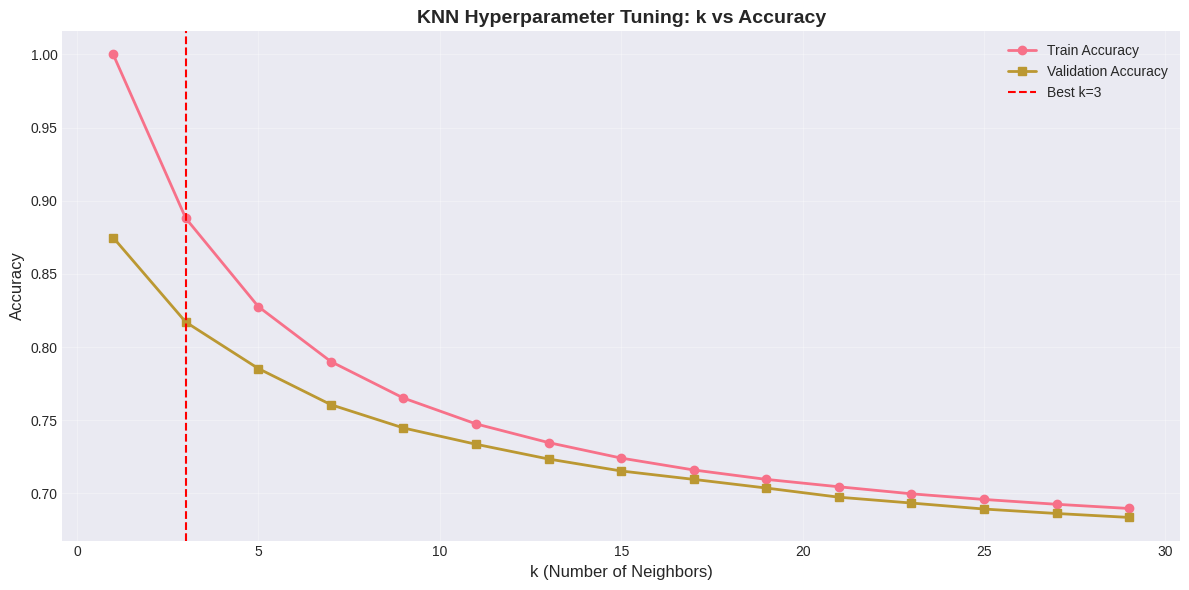

In [41]:
# Plot hyperparameter tuning results
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, marker='o', label='Train Accuracy', linewidth=2)
plt.plot(k_values, val_scores, marker='s', label='Validation Accuracy', linewidth=2)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('k (Number of Neighbors)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('KNN Hyperparameter Tuning: k vs Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('knn_hyperparameter_tuning.png', dpi=300, bbox_inches='tight')
plt.show()

# 💡 **Why We Use Scikit-learn for KNN and Not PyTorch**

This approach is deliberate for the following reasons:



1.   Framework Purpose: PyTorch is an AutoDiff library fundamentally built for building Deep Learning models (like Neural Networks) that rely on gradient calculation and backpropagation for training.

2.   KNN's Nature: K-Nearest Neighbors (KNN) is a non-parametric, non-differentiable algorithm. It requires no training and has no weights to optimize via gradients.

2.   Optimization and Reliability: Scikit-learn provides the canonical, highly optimized, and production-ready implementation for classic machine learning algorithms like KNN, generally offering better performance and stability for this specific task than a manual PyTorch implementation.


In short, while we prepare our data as PyTorch Tensors for potential future use with a Neural Network, Scikit-learn is the correct, industry-standard tool for tuning the KNN classifier.

In [42]:
# Train final model with best k
print(f"\n{'='*60}")
print("TRAINING FINAL MODEL")
print(f"{'='*60}")

final_knn = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
final_knn.fit(X_train_vec, y_train)


TRAINING FINAL MODEL


KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [43]:
# Evaluate on all sets
train_pred = final_knn.predict(X_train_vec)
val_pred = final_knn.predict(X_val_vec)
test_pred = final_knn.predict(X_test_vec)

In [44]:
# Calculate metrics for each set
def print_metrics(y_true, y_pred, dataset_name):
    print(f"\n{dataset_name} Set Metrics:")
    print(f"  Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"  Recall:    {recall_score(y_true, y_pred):.4f}")
    print(f"  F1-Score:  {f1_score(y_true, y_pred):.4f}")

print_metrics(y_train, train_pred, "Training Accuracy")
print_metrics(y_val, val_pred, "Validation Accuracy")
print_metrics(y_test, test_pred, "Test Accuracy")


Training Accuracy Set Metrics:
  Accuracy:  0.8880
  Precision: 0.8287
  Recall:    0.9977
  F1-Score:  0.9054

Validation Accuracy Set Metrics:
  Accuracy:  0.8171
  Precision: 0.7479
  Recall:    0.9947
  F1-Score:  0.8538

Test Accuracy Set Metrics:
  Accuracy:  0.8205
  Precision: 0.7517
  Recall:    0.9938
  F1-Score:  0.8560


In [45]:
# Detailed classification report for test set
print(f"\n{'='*60}")
print("DETAILED TEST SET CLASSIFICATION REPORT")
print(f"{'='*60}")
print(classification_report(y_test, test_pred, target_names=['Safe Email', 'Phishing Email']))


DETAILED TEST SET CLASSIFICATION REPORT
                precision    recall  f1-score   support

    Safe Email       0.99      0.62      0.76      5326
Phishing Email       0.75      0.99      0.86      6176

      accuracy                           0.82     11502
     macro avg       0.87      0.81      0.81     11502
  weighted avg       0.86      0.82      0.81     11502



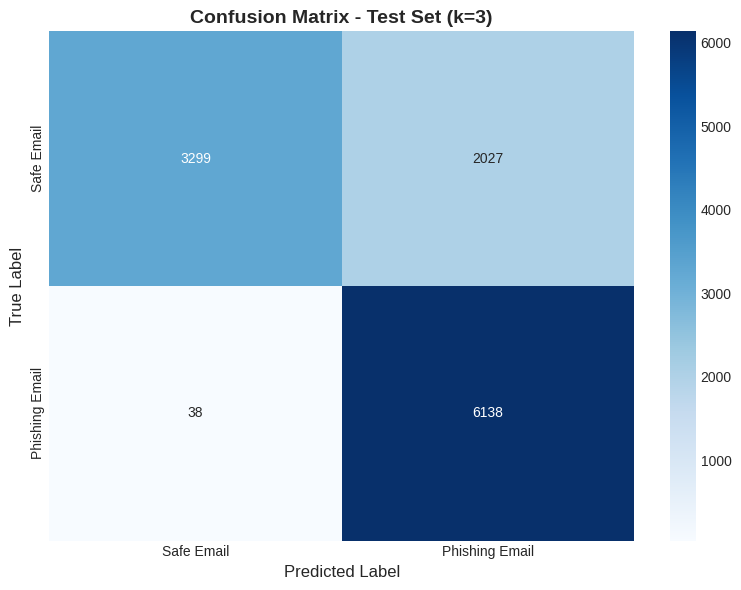

In [46]:
# Confusion Matrix for test set
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Safe Email', 'Phishing Email'],
            yticklabels=['Safe Email', 'Phishing Email'])
plt.title(f'Confusion Matrix - Test Set (k={best_k})', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [47]:
# Summary
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")
print(f"Best k value: {best_k}")
print(f"Test Accuracy: {accuracy_score(y_test, test_pred):.4f}")
print(f"Test F1-Score: {f1_score(y_test, test_pred):.4f}")
print(f"\nModel saved as 'final_knn' and vectorizer as 'vectorizer'")


FINAL SUMMARY
Best k value: 3
Test Accuracy: 0.8205
Test F1-Score: 0.8560

Model saved as 'final_knn' and vectorizer as 'vectorizer'


In [49]:
# Example prediction function
def predict_email(email_text):
    """Predict if an email is phishing or safe"""
    email_vec = vectorizer.transform([email_text])
    prediction = final_knn.predict(email_vec)[0]
    proba = final_knn.predict_proba(email_vec)[0]

    label = "Phishing Email" if prediction == 1 else "Safe Email"
    confidence = proba[prediction] * 100

    return label, confidence

# Testing with a sample email
print(f"\n{'='*60}")
print("EXAMPLE PREDICTION")
print(f"{'='*60}")
sample_email = X_test[0]
true_label = y_test[0]

pred_label, confidence = predict_email(sample_email)
print(f"Email: {sample_email[:100]}...")
print(f"True Label: {'Phishing Email' if true_label == 1 else 'Safe Email'}")
print(f"Prediction: {pred_label}")
print(f"Confidence: {confidence:.2f}%")


EXAMPLE PREDICTION
Email: never agree to be a loser buck up, your troubles caused by small dimension will soon be over! become...
True Label: Phishing Email
Prediction: Phishing Email
Confidence: 100.00%
